## Домашнее задание №3

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [34]:
from typing import List

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision.datasets import MNIST
import sys


device = torch.device('cuda')

### Задача №1: 
Вернемся к задаче распознавания рукописных цифр, рассмотренной на первом занятии. Все также будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 8')

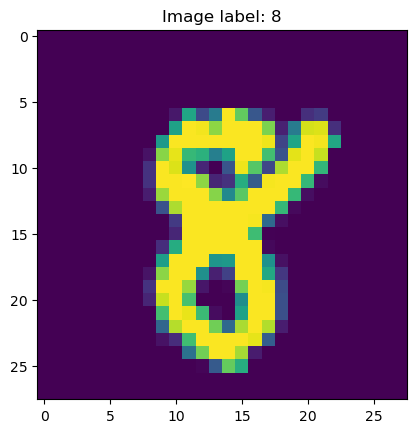

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Text(0.5, 1.0, 'Image label: 1')

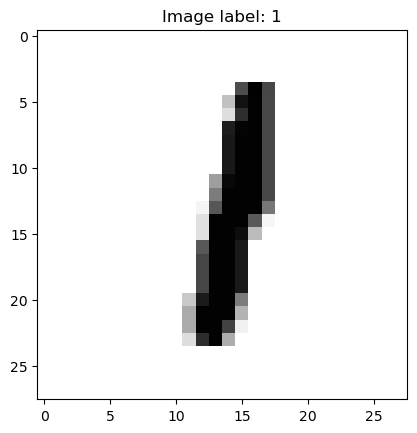

In [5]:
random_batch = next(iter(train_data_loader))
_image, _label = 1 - random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28), cmap='gray')
plt.title(f'Image label: {_label}')

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [39]:
# Creating model instance
class MyModel(nn.Module):
    def __init__(self, input_size: int, hidden_layers: List[int], output_size: int):
        super().__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))

        # Output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.layers[-1](x)
        return x


model = MyModel(28 * 28, [32, 4], 10)  # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [24]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e

assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. В качестве примера можете воспользоваться ноутбуком с занятия №1. Также рекомендуем поработать с различными оптимизаторами.

In [40]:
# your code here


optimizer = optim.Adam(params=model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 4
model.to(device)
model.train()

for _e in range(epochs):
    correct = 0
    total = 0
    for i, (x_batch, y_batch) in enumerate(train_data_loader):
        x_batch = x_batch.view(x_batch.size(0), -1).to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        # Update progress every 100 iterations
        if (i + 1) % 100 == 0:
            sys.stdout.write(f'Iteration [{i + 1}], Loss: {loss.item():.4f}\r')
            sys.stdout.flush()

    accuracy = 100 * correct / total
    print(f'Epoch [{_e + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/4], Loss: 0.6350, Accuracy: 67.07%
Epoch [2/4], Loss: 0.6800, Accuracy: 87.79%
Epoch [3/4], Loss: 0.2843, Accuracy: 90.47%
Epoch [4/4], Loss: 0.2303, Accuracy: 91.67%


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [49]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].to(device).reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels).to(device)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.9252


In [50]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].to(device).reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels).to(device)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
print(f'Neural network accuracy on test set: {test_acc:3.5}')


Neural network accuracy on test set: 0.9177


Проверка, что необходимые пороги пройдены:

In [11]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

AssertionError: Test accuracy is below 0.92 threshold

### Сдача задания
Загрузите файл `hw03_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy

In [72]:
import codecs
import json
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists(
    'hw03_data_dict.npy'), 'Please, download `hw03_data_dict.npy` and place it in the working directory'


def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx + step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels


loaded_data_dict = np.load('hw03_data_dict.npy', allow_pickle=True)

# Create submission dictionary
submission_dict = {
    'train': ','.join(str(_) for _ in get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy().tolist()),
    'test': ','.join(str(_) for _ in get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy().tolist())
}

# Save submission dictionary as a JSON file
file_path = "submission_dict_hw03.npy"  # your path variable
json.dump(submission_dict, codecs.open(file_path, 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)  # this saves the array in .json format

print('File saved to', file_path)
# __________end of block__________

File saved to submission_dict_hw03.npy


На этом задание завершено. Поздравляем!